# Sprocket Central - Customer Classifier and Purchase Predictor

### Helping a small bike shop (Sprocket Central) maximize their CRM's customer data and transaction history, we use applied stats and machine learning to help them predict which customers will likely be repeat customers, in order to help maximize their marketing ROI and drive/predict new sales.

# Data Input

#### Package Installations

In [1]:
# Initializing packages
import os # Operating system package

import numpy as np # Numpy package for list and array operations
import pandas as pd # Pandas package for dataframe operations

from sklearn.preprocessing import LabelEncoder # SKlearn package to label encode categorical variables (to numbers)

import seaborn as sns # Seaborn package for graphs and visualizations
import matplotlib.pyplot as plt # Matplotlib package for graphs and visualizations

from sklearn.model_selection import train_test_split # SKlearn package for creating train / test dataset
from sklearn.model_selection import KFold # Sklearn package for implementing K-Fold Validation
from sklearn.model_selection import StratifiedKFold # Sklearn package for Stratified K Fold

from sklearn import tree # Sklearn package for decision trees
import graphviz # Package for using decision trees that are customizable
from sklearn.ensemble import GradientBoostingClassifier # Sklearn package for Gradient Boosting Classifer

from sklearn import metrics # Sklearn package for scoring predictive models
from sklearn.metrics import precision_recall_fscore_support as score, precision_score, recall_score, f1_score # Package for evaluation metrics
from sklearn.model_selection import cross_val_score # Sklearn package for using cross-validation
from sklearn.metrics import confusion_matrix # Sklean package for implementing confusion matrix
from sklearn.metrics import roc_auc_score, roc_curve # Package for calculating AUC and ROC scores
from sklearn.metrics import jaccard_score # Sklearn package for calculating jaccard score

from sklearn.metrics import classification_report # Multiclass classification reports

### Data Import
#### - Customer Data
#### - Transaction Data

In [2]:
# Setting directory to saved data from KPMG Virtural Internship
os.chdir('C:\\Users\\marky\\OneDrive\\Documents\\Data Science\\Project Portfolio\\KPMG Internship - New Customer Profit Predictor\\')

# Reading in CSV into dataframe
customer_demographic_data = pd.read_excel('Sprocket Central Data - KPMG.xlsx',sheet_name='CustomerDemographic',skiprows=1)
customer_address_data = pd.read_excel('Sprocket Central Data - KPMG.xlsx',sheet_name='CustomerAddress',skiprows=1)
transactions_data = pd.read_excel('Sprocket Central Data - KPMG.xlsx',sheet_name='Transactions',skiprows=1)

In [3]:
# Easy reset of values # Debugging / building purposes
customer_demographic = customer_demographic_data
customer_address = customer_address_data
transactions = transactions_data

In [4]:
customer_demographic.count()

customer_id                            4000
first_name                             4000
last_name                              3875
gender                                 4000
past_3_years_bike_related_purchases    4000
DOB                                    3913
job_title                              3494
job_industry_category                  3344
wealth_segment                         4000
deceased_indicator                     4000
default                                3698
owns_car                               4000
tenure                                 3913
dtype: int64

In [5]:
customer_address.count()

customer_id           3999
address               3999
postcode              3999
state                 3999
country               3999
property_valuation    3999
dtype: int64

In [6]:
transactions.count()

transaction_id             20000
product_id                 20000
customer_id                20000
transaction_date           20000
online_order               19640
order_status               20000
brand                      19803
product_line               19803
product_class              19803
product_size               19803
list_price                 20000
standard_cost              19803
product_first_sold_date    19803
dtype: int64

### Data Cleaning
#### - Transactions

In [7]:
# Measure shape before cleaning
shape_transactions = transactions.shape

# Drop rows with missing information (price, brand) that cannot be imputted from other areas, since most data that 
# is missing for each row has missing data across multple columns
transactions = transactions.dropna()

# Removing 'cancelled' transactions
transactions = transactions[transactions['order_status'] != 'Cancelled']

# Fill in empty values in online order to '0.0', since '1.0' would be for an online order
# Assumming missing values are in-store purchases
transactions['online_order'] = transactions['online_order'].fillna(0.0)

# Measure shape after cleaning
shape_transactions_clean = transactions.shape

# Comparing difference cleaning made
print("Dataframe shape from",shape_transactions,"to",shape_transactions_clean,'\n')

# Verifying that there are no duplicate entries
print('Duplicates Tally:',transactions.duplicated().value_counts())

Dataframe shape from (20000, 13) to (19273, 13) 

Duplicates Tally: False    19273
dtype: int64


In [8]:
transactions.count()

transaction_id             19273
product_id                 19273
customer_id                19273
transaction_date           19273
online_order               19273
order_status               19273
brand                      19273
product_line               19273
product_class              19273
product_size               19273
list_price                 19273
standard_cost              19273
product_first_sold_date    19273
dtype: int64

#### - Customers

In [9]:
# Merge 'customer' dataframes
customers = customer_demographic.merge(customer_address,left_on='customer_id',right_on='customer_id')

# Measure shape before cleaning
shape_customers = customers.shape

# Drop rows with missing information (DOB) that cannot be imputted from other areas
customers = customers.dropna(subset=['DOB'])

# Drop outliers in age
customers = customers[customers['DOB'].dt.year > 1900]

# Removing customers that are 'Y' for deceased
customers = customers[customers['deceased_indicator'] != 'Y']

# Format 'Gender' column
customers[['gender']]=customers[['gender']].replace(['Femal','F'],'Female').replace(['M'],'Male')

# Format 'State' column
customers[['state']] = customers[['state']].replace('New South Wales','NSW').replace('Victoria','VIC')

#Fill in the rest of the missing empty values with 'N/A', since they are strings and won't be used for calculations
customers.fillna('N/A',inplace=True)

# Drop unnecessary columns column
customers.drop(columns = ['first_name','last_name','job_title','deceased_indicator','default','address','postcode','country'],inplace=True)

# Measure shape after cleaning
shape_customers_clean = customers.shape

# Comparing difference cleaning made
print("Dataframe shape from",shape_customers,"to",shape_customers_clean,'\n')

# Verifying that there are no duplicate entries
print('Duplicates Tally:',customers.duplicated().value_counts())

Dataframe shape from (3996, 18) to (3906, 10) 

Duplicates Tally: False    3906
dtype: int64


In [10]:
customers.count()

customer_id                            3906
gender                                 3906
past_3_years_bike_related_purchases    3906
DOB                                    3906
job_industry_category                  3906
wealth_segment                         3906
owns_car                               3906
tenure                                 3906
state                                  3906
property_valuation                     3906
dtype: int64

## Create Calculations and Bins (Feature Engineering)
#### - Transactions

In [11]:
# Not in use
# Creating columns related to profits, to keep net profits as the target variable (versus costs)
#transactions['product_profit'] = (transactions['list_price']-transactions['standard_cost'])
#transactions['profit_margin'] = (1-(transactions['standard_cost']/transactions['list_price']))

#### - Customers - Address and Demographics

In [12]:
# Develop columns (i.e, age)
# customers

# Develop age column
now = pd.to_datetime('now')
customers['age']=(now - customers['DOB']).astype('<m8[Y]')
# Drop DOB column, since age was created to replace it
customers.drop(columns = ['DOB'], inplace=True)

# Develop bins (i.e, property value, generation (age), senority (tenure)) -- after initial plots
# customers

# Age bin

# Property Bin

# 3 Year Purchase Bin

# Tenure Bin

# Unclassified Group Bin (via PCA)

# customers.head()

#### - Customers - Profits and Purchases

# Create 'purchase_behavior' bin based on customer purchases - occasional, frequent, enthusiast

In [13]:
# Groupby by 'customer_id' 
customers_transactions = pd.DataFrame()

# # Bin customers by 'products bought'
bins = [0, 3, 6, 9, 12, 15] # For graphing bins
# #customers_transactions['purchase_group'] = pd.cut(transactions.groupby(['customer_id'])['transaction_id'].count(), bins)

# Multipurchases | Group by number of transactions, then replace single purchases to 0 and multipurchases to 1
customers_transactions['multiple_purchases'] = transactions.groupby(['customer_id'])['transaction_id'].nunique().replace(1,0).replace([2,3,4,5,6,7,8,9,10,11,12,13,14],1)

# Reset index so data can be merged by 'customer_id' column
customers_transactions = customers_transactions.reset_index()

### - Merge Customers - Address / Demographics / Profits / Purchases

In [14]:
# Merge 'customer' dataframe with customer transactions
customers = customers.merge(customers_transactions,left_on='customer_id',right_on='customer_id')

# Set customers as index
customers.set_index('customer_id', inplace=True)

# Measure shape after merge
shape_customers_merge = customers.shape

# Comparing difference cleaning made
print("Dataframe shape from",shape_customers_clean,"to",shape_customers_merge,'\n')

Dataframe shape from (3906, 10) to (3407, 10) 



In [15]:
customers.count()

gender                                 3407
past_3_years_bike_related_purchases    3407
job_industry_category                  3407
wealth_segment                         3407
owns_car                               3407
tenure                                 3407
state                                  3407
property_valuation                     3407
age                                    3407
multiple_purchases                     3407
dtype: int64

# Exploratory Data Analysis and Feature Engineering

### Customers

In [16]:
# Preview
customers

,gender,past_3_years_bike_related_purchases,job_industry_category,wealth_segment,owns_car,tenure,state,property_valuation,age,multiple_purchases
customer_id,,,,,,,,,,
1,Female,93,Health,Mass Customer,Yes,11.0,NSW,10,66.0,1
2,Male,81,Financial Services,Mass Customer,Yes,16.0,NSW,10,39.0,1
4,Male,33,IT,Mass Customer,No,7.0,QLD,9,58.0,1
5,Female,56,N/A,Affluent Customer,Yes,8.0,NSW,4,43.0,1
6,Male,35,Retail,High Net Worth,Yes,13.0,VIC,9,53.0,1
...,...,...,...,...,...,...,...,...,...,...
3496,Male,99,Manufacturing,Mass Customer,Yes,19.0,NSW,9,34.0,1
3497,Female,73,Manufacturing,Affluent Customer,Yes,18.0,VIC,5,34.0,1
3498,Female,28,Manufacturing,Mass Customer,No,5.0,VIC,4,24.0,1


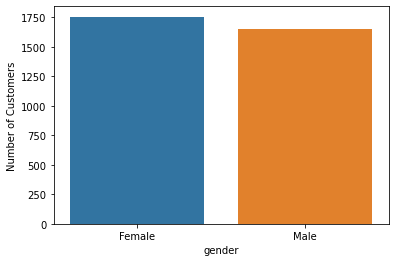

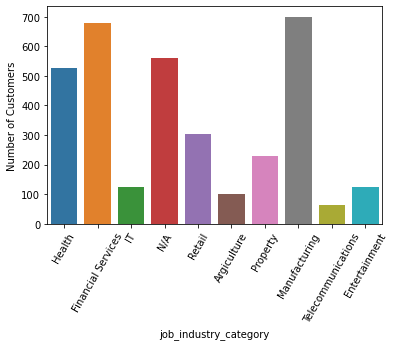

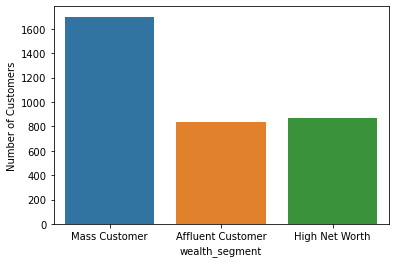

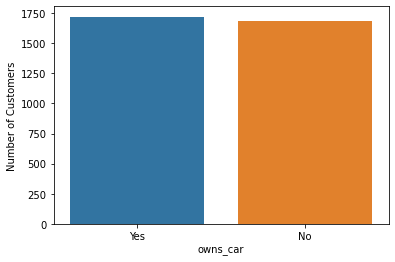

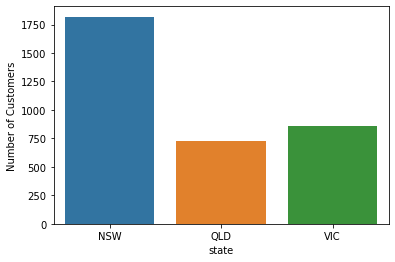

In [17]:
customers_categories = customers.select_dtypes(exclude=np.number)

# Plot
for column_id in customers_categories.columns:
    plt.figure(column_id)
    sns.countplot(x = column_id, data = customers_categories)
    plt.ylabel('Number of Customers')
    if column_id == 'job_industry_category':
        plt.xticks(rotation=60)

# One-Hot Encode

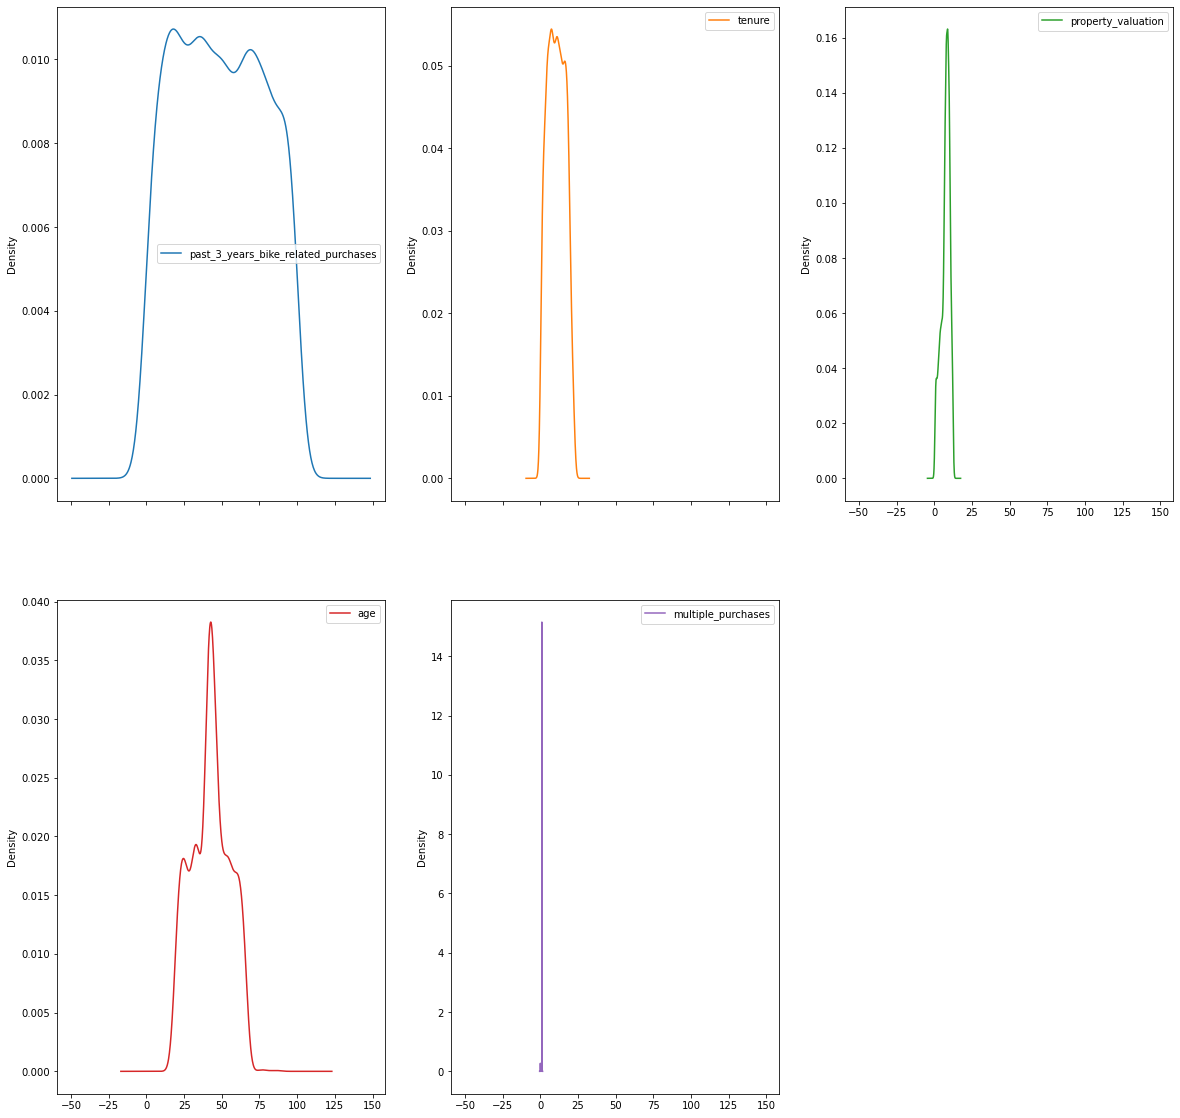

In [18]:
customers_numbers = customers.select_dtypes(include=np.number)

# Plot
customers_numbers.plot(kind='kde',subplots=True,layout=(2,3), figsize = (20,20));

# Normalize

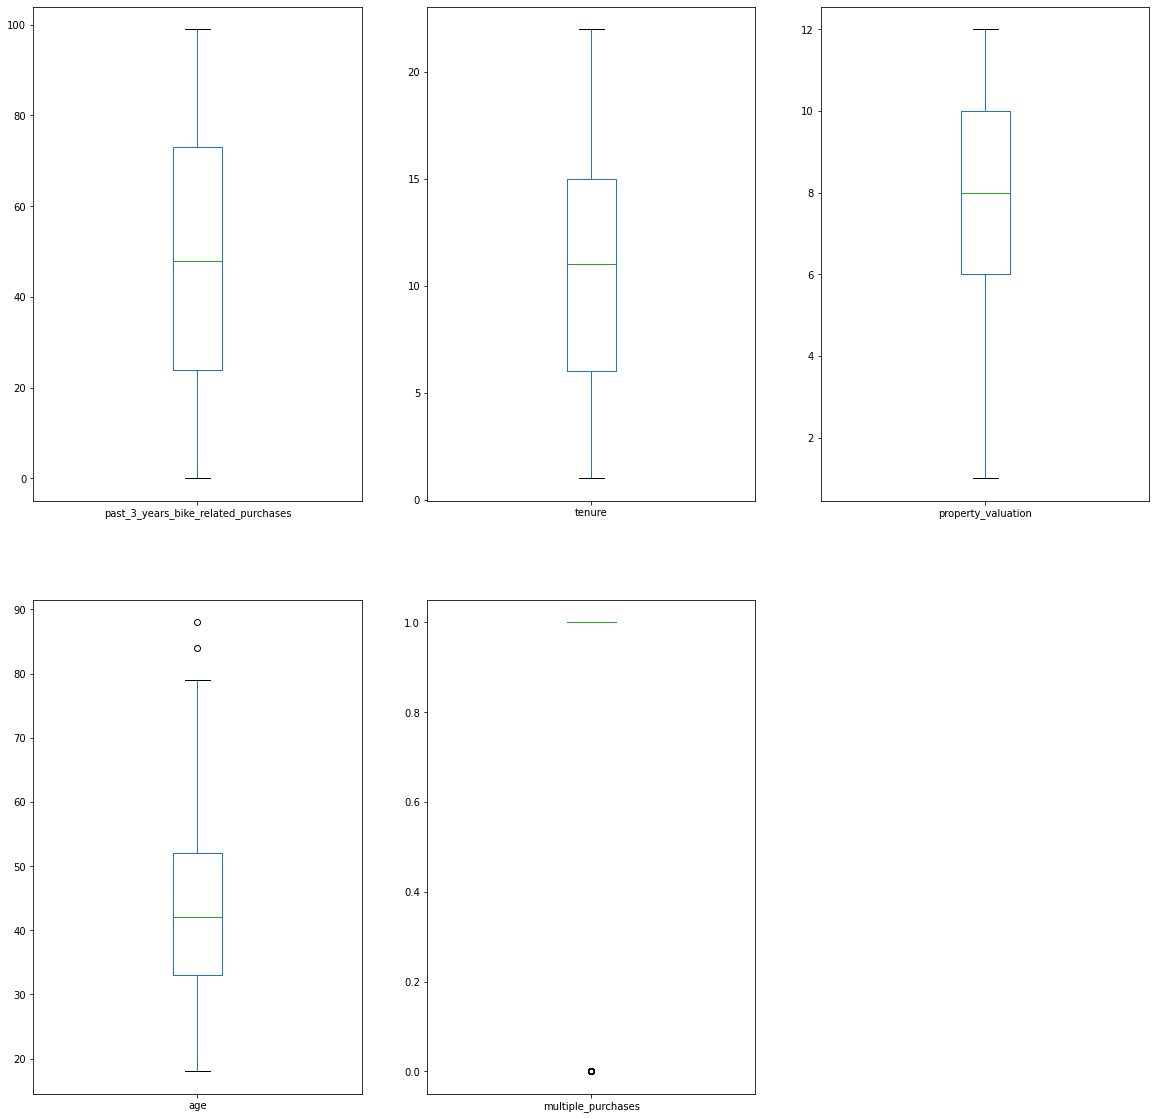

In [19]:
# Plot
customers_numbers.plot(kind='box',subplots=True,layout=(2,3), figsize = (20,20));

In [20]:
# Merge and put into 'customer_model_data' with 'multiple_purchases' as last column

# customers_model_data = 

Label encode categorical columns (Delete / raw data when one-hot coding enabled (above))

In [21]:
# Select categorical columns and apply one-hot encoding to them - save to 'model_data'

customers_model_data = customers
# customers_model_data[customers_model_data.select_dtypes(exclude=np.number).columns] = customers_model_data.select_dtypes(exclude=np.number).apply(LabelEncoder().fit_transform)

# Select categorical columns and apply label encoding to them
customers_model_data[customers.select_dtypes(exclude=np.number).columns] = customers.select_dtypes(exclude=np.number).apply(LabelEncoder().fit_transform)

customers_model_data.head()

,gender,past_3_years_bike_related_purchases,job_industry_category,wealth_segment,owns_car,tenure,state,property_valuation,age,multiple_purchases
customer_id,,,,,,,,,,
1,0,93,3,2,1,11.0,0,10,66.0,1
2,1,81,2,2,1,16.0,0,10,39.0,1
4,1,33,4,2,0,7.0,1,9,58.0,1
5,0,56,6,0,1,8.0,0,4,43.0,1
6,1,35,8,1,1,13.0,2,9,53.0,1


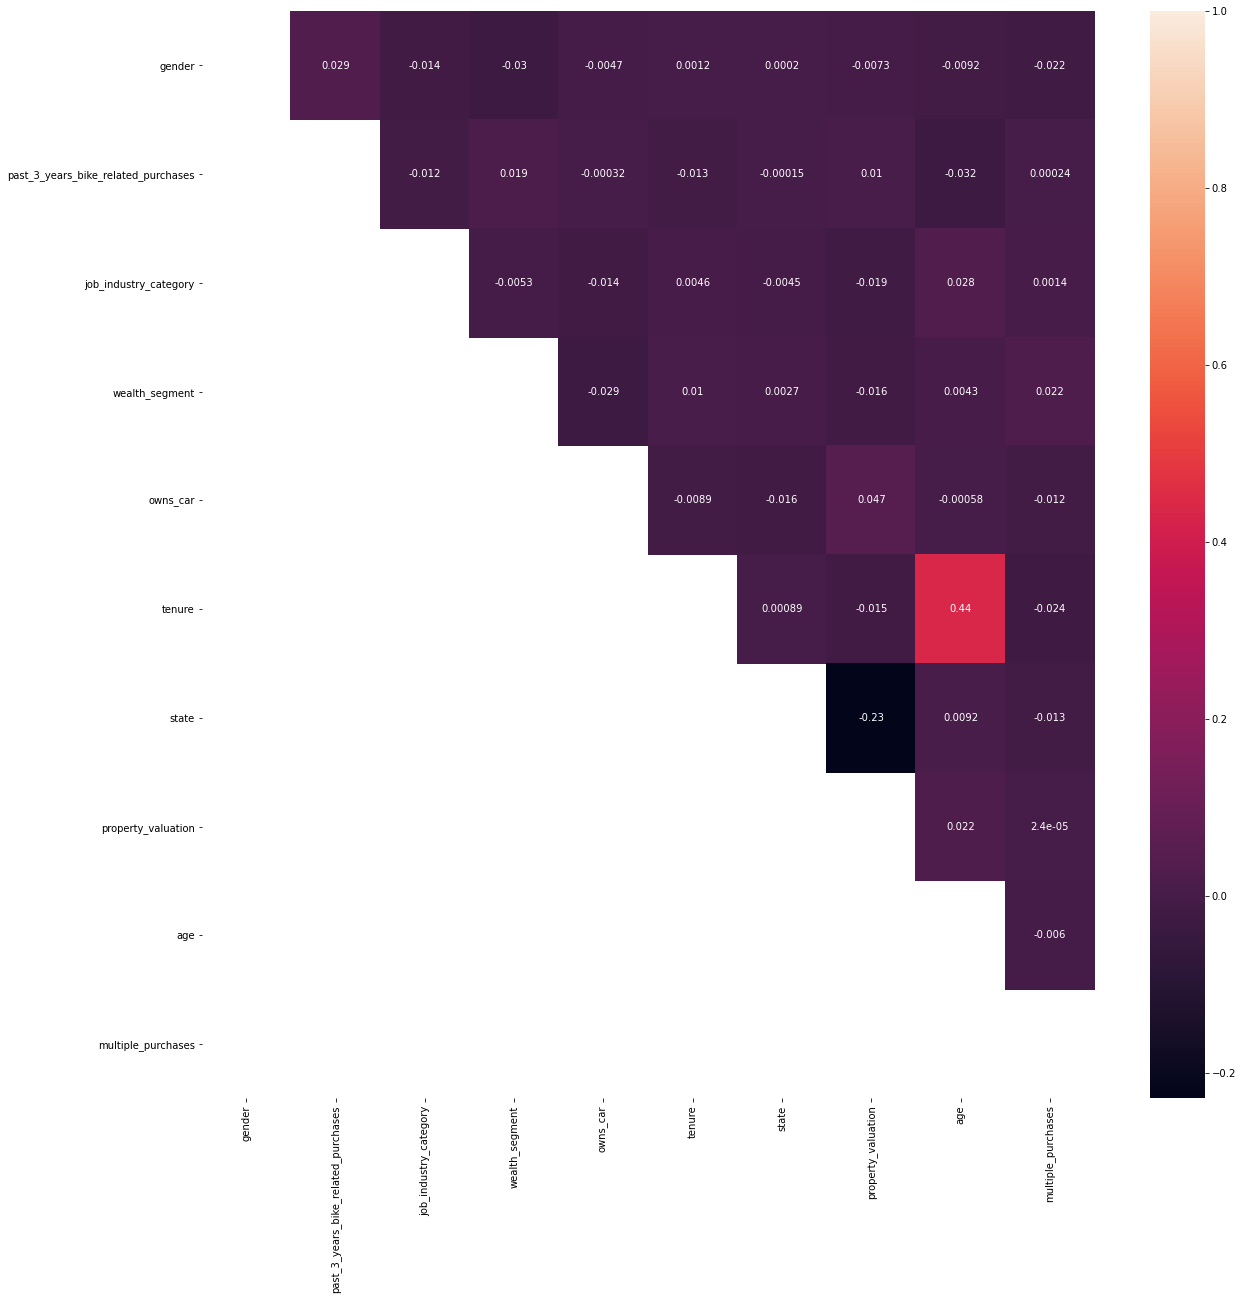

In [22]:
plt.figure(figsize=(20, 20))

sns.heatmap(customers_model_data.corr(), annot = True, mask = np.tril(customers_model_data.corr()));

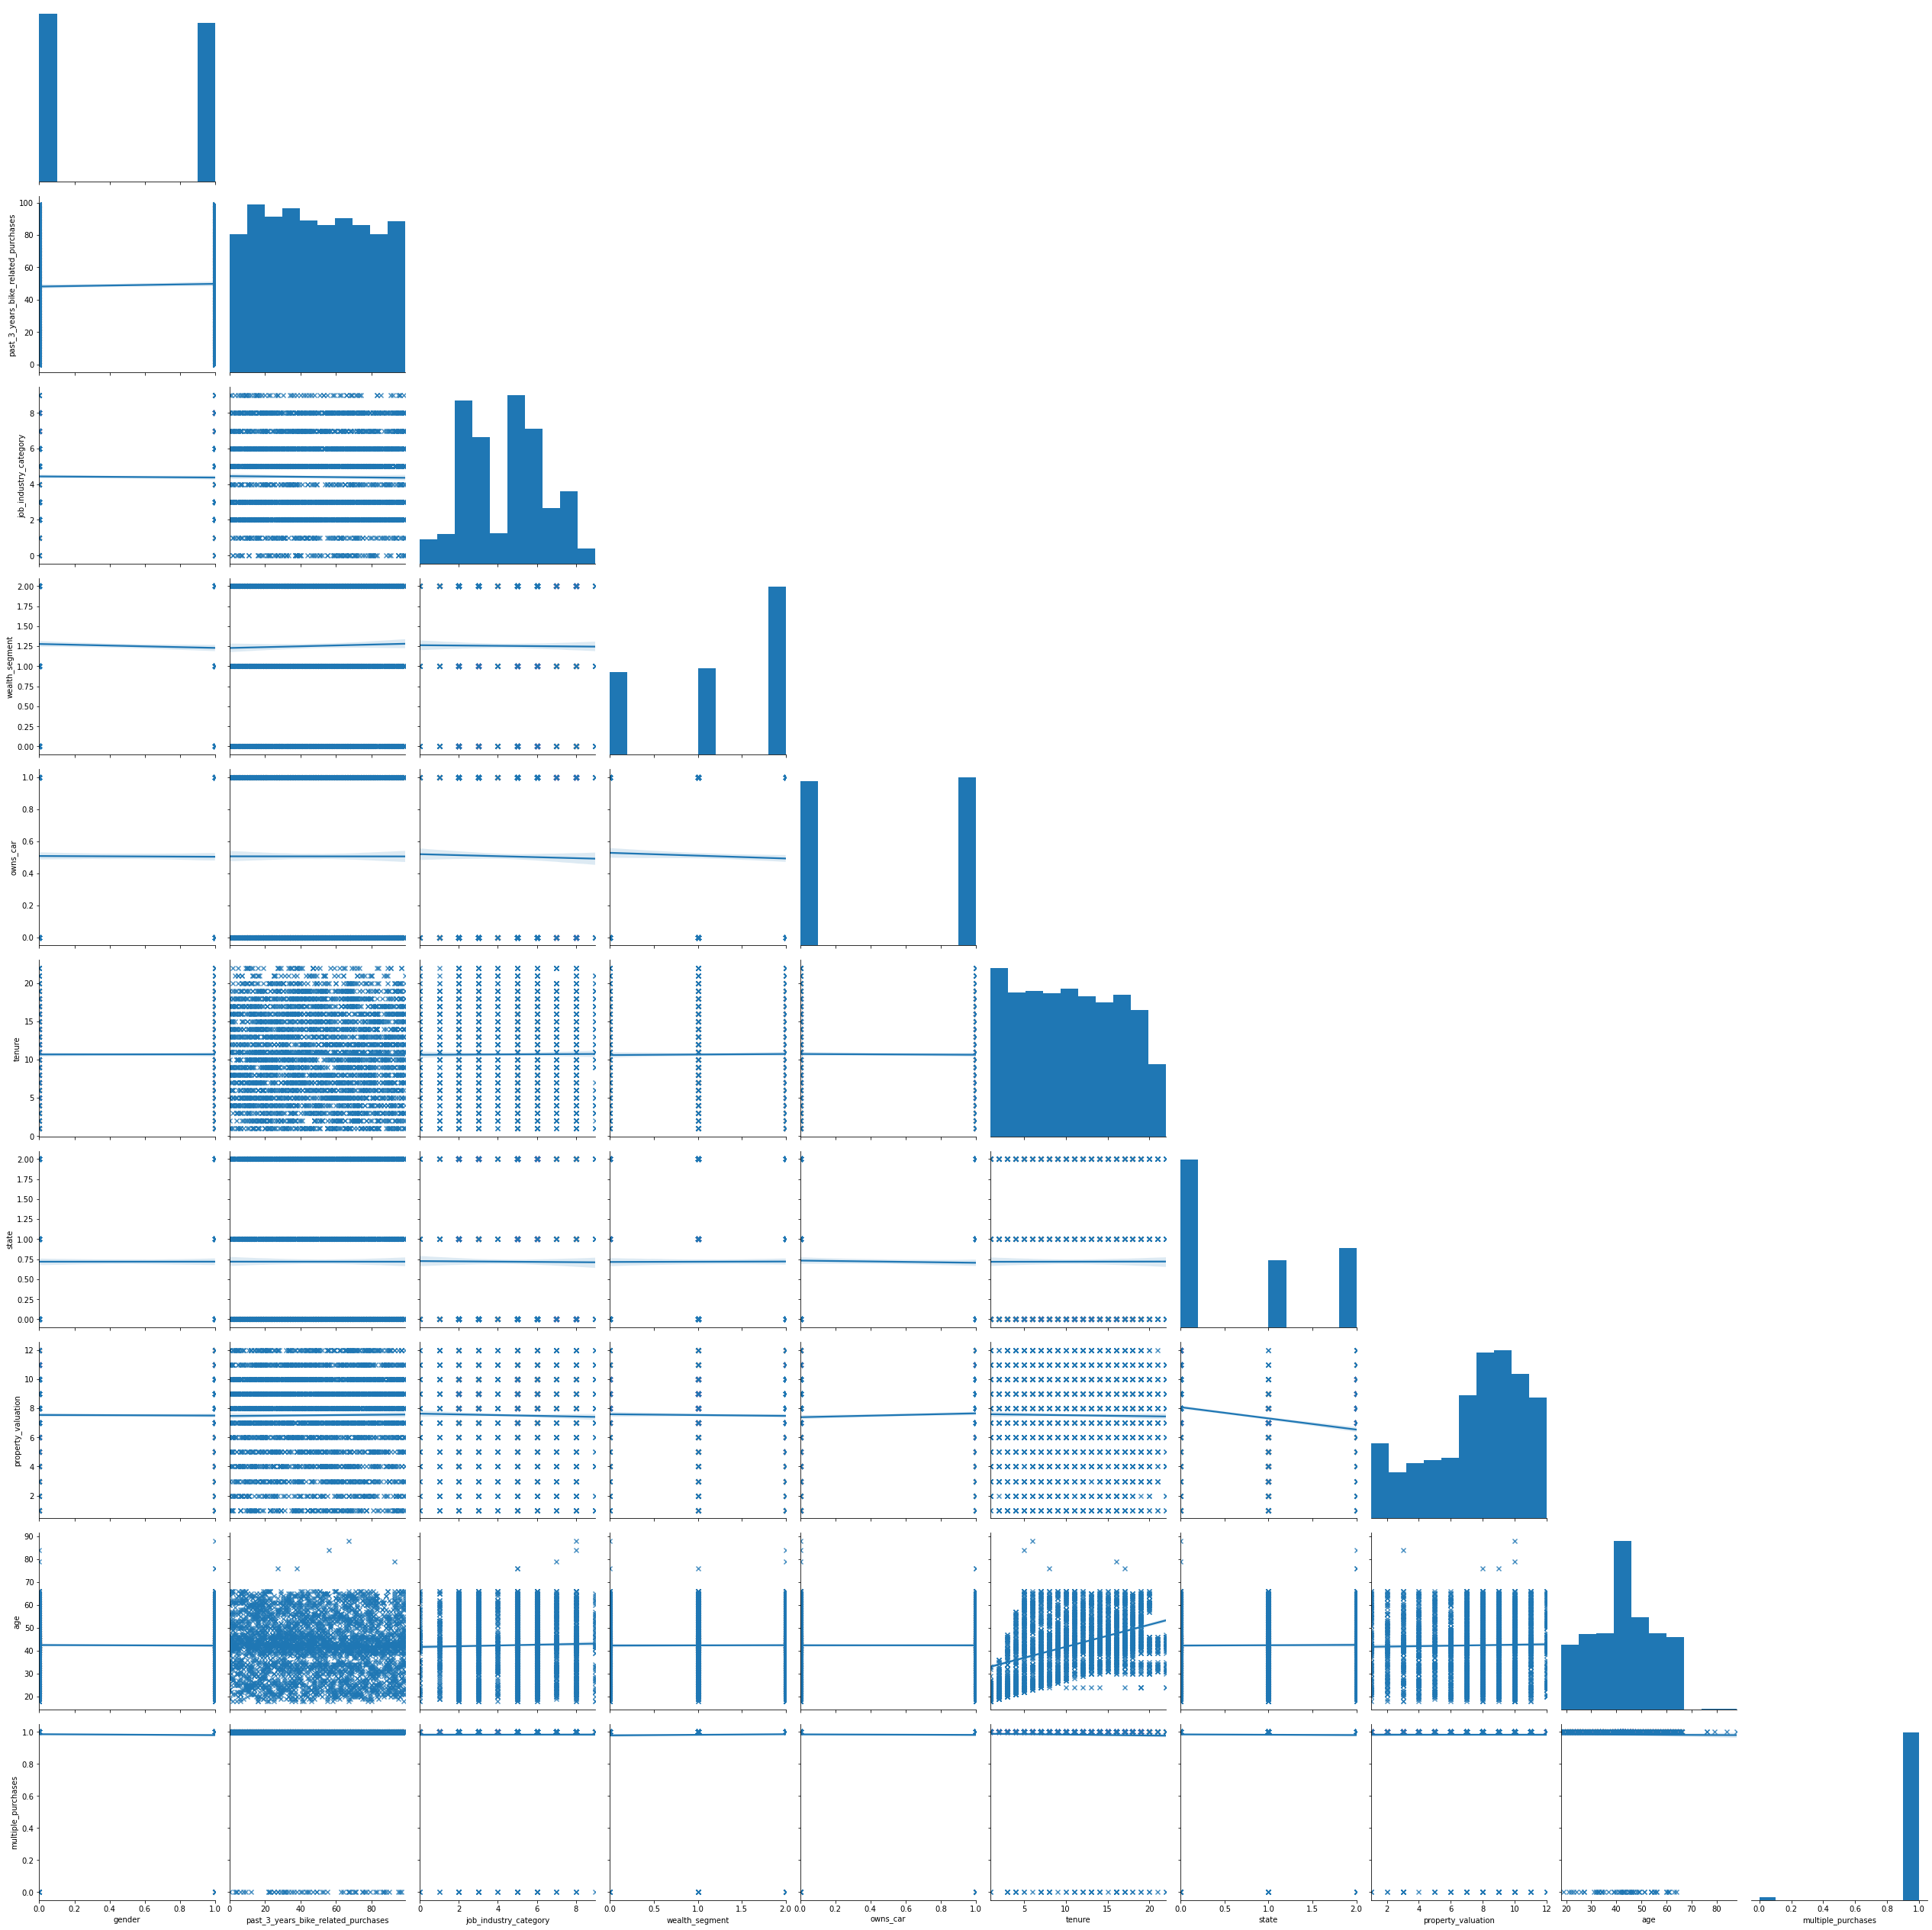

In [23]:
sns.pairplot(customers_model_data, height = 3.5, markers = 'x', kind = 'reg', corner = True);
# Or 'customers_numbers'

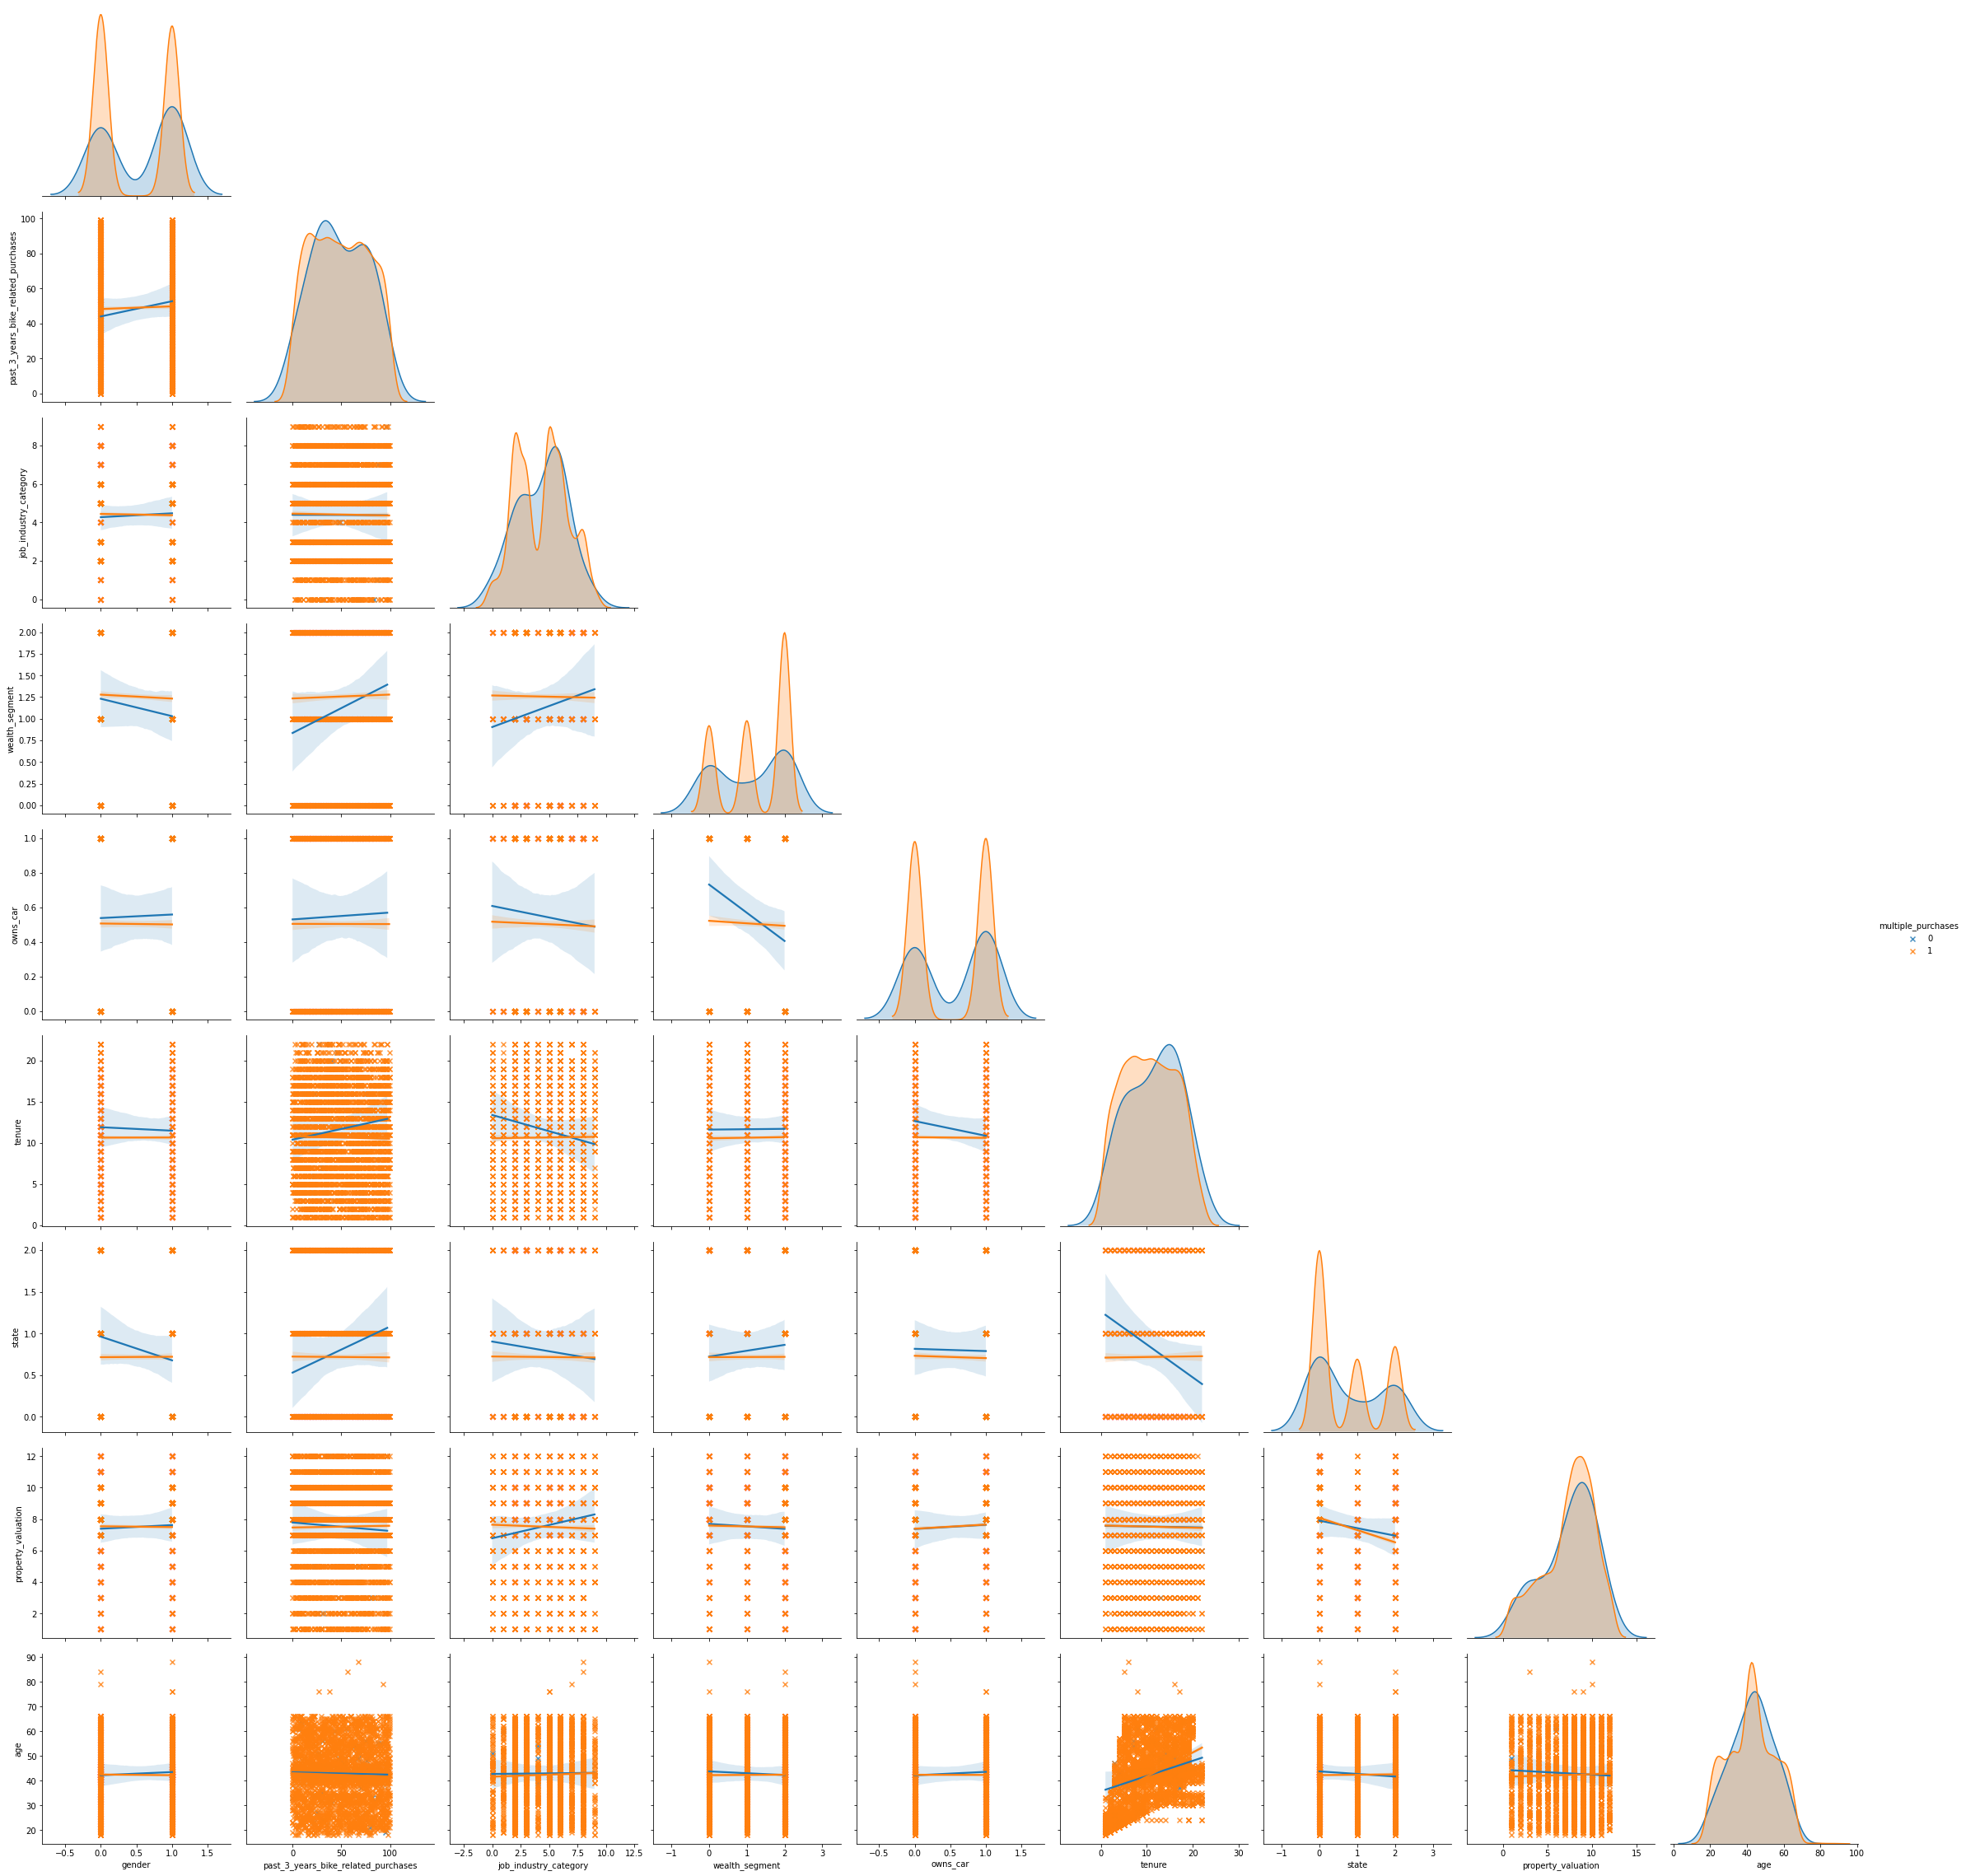

In [24]:
customers_pairplot_multipurchase = sns.pairplot(customers_model_data, height = 3.5, markers = 'x', kind = 'reg', corner = True, hue = 'multiple_purchases')

# Saving to 'png' image
# customers_pairplot_multipurchase.savefig("customers pairplot multipurchase.png")

customers_pairplot_multipurchase;

#### Remove Outliers

#### Find skewed data and apply logistic transformation

## Map Customers
#### Customers
    - Wealth and Products Bought (Bubble Plot)

Determine if living in big city or not by GPS coordinates / address

# Predictive Models

## Build Test /Train Dataset

In [25]:
# Set dependent vartiables (X) and independent/target variable (y) 
# X
X = customers_model_data.drop(columns=customers_model_data.columns[~0])

# y
y = pd.DataFrame(customers_model_data.iloc[:,-1])
print('Target variable:',y.columns.values)

# Create Test / Train split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

# # Create Test / Train split - with Y stratified (optional) - Didn't help score
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0, stratify = y)

split = 10

Target variable: ['multiple_purchases']


Linear Regression Classification

## Decision Tree Classification

In [26]:
# Build decision tree classifier
clf = tree.DecisionTreeClassifier(criterion='gini', max_depth = 7).fit(X_train, y_train)

#Build boost gradient classifier
# clf = GradientBoostingClassifier(max_depth = 7).fit(X_train, y_train)

# Predict target values for y_test, using our Classifier and X_test
pred = clf.predict(X_test)

# Feature importance - from most to least
pd.DataFrame(clf.feature_importances_,index=X.columns,columns=['Feature Importance']).sort_values(by=['Feature Importance'],ascending=False)

,Feature Importance
property_valuation,0.262376
age,0.259016
past_3_years_bike_related_purchases,0.223929
tenure,0.086241
job_industry_category,0.078935
wealth_segment,0.047979
owns_car,0.017227
state,0.012546
gender,0.011751


In [27]:
#scores = cross_val_score(clf, X, y, cv=split)
#scores

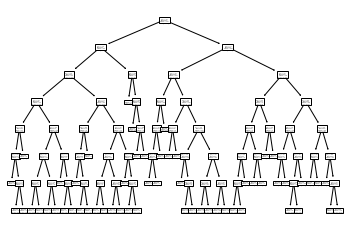

In [28]:
tree.plot_tree(clf);

#### - Measure Model Performance

In [29]:
print('The classification accurracy is', round(clf.score(X,y)*100,2,),'% on the validation set\n')

print('Precision Score:', precision_score(y_test, pred),'- ratio of True Positives to all positives')
print('Jaccard Score:  ', jaccard_score(y_test, pred)) 
print('Recall Score:', recall_score(y_test, pred),' - ratio of True Positives to all positives predicted')
print('F1 Score:    ', f1_score(y_test, pred),'- ratio of False Negatives to all negatives predicted')

print('')

print('Mean Absolute Error:    ', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error:     ', metrics.mean_squared_error(y_test, pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

# For multiclass scores
print('\n',classification_report(y_test, clf.predict(X_test)))

The classification accurracy is 98.53 % on the validation set

Precision Score: 0.9852507374631269 - ratio of True Positives to all positives
Jaccard Score:   0.9794721407624634
Recall Score: 0.9940476190476191  - ratio of True Positives to all positives predicted
F1 Score:     0.9896296296296296 - ratio of False Negatives to all negatives predicted

Mean Absolute Error:     0.020527859237536656
Mean Squared Error:      0.020527859237536656
Root Mean Squared Error: 0.14327546627925053

               precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.99      0.99      0.99       672

    accuracy                           0.98       682
   macro avg       0.49      0.50      0.49       682
weighted avg       0.97      0.98      0.98       682



#### - Confusion Matrix

In [30]:
confusion_matrix(y_test, pred)

array([[  0,  10],
       [  4, 668]], dtype=int64)

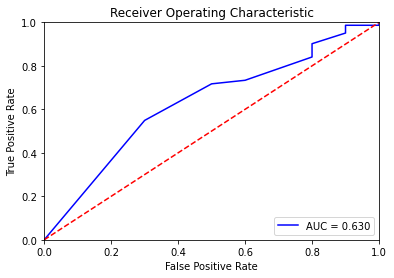

In [31]:
# calculate the fpr and tpr for all thresholds of the classification
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC AUC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [32]:
# Implement Boost Gradient Classifier - Compare Score


## Refine Model